In [32]:
# Necessary Imports
import os
import cv2
import numpy as np
from skimage import feature
from sklearn.preprocessing import LabelEncoder
from glob import glob

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [2]:
def get_image_names_in_folder(folder_path):
    image_names = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_names.append(os.path.join(root, file))
    return image_names

In [15]:
def preprocess_image(image_path, orientations, pixels_per_cell, cells_per_block, transform_sqrt, block_norm):
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = feature.hog(image,
                           orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           transform_sqrt=transform_sqrt,
                           block_norm=block_norm)
    return features, label

In [25]:
PATH = "./dataset/spiral" 

X_PATH = os.path.sep.join([PATH, "training"])
y_PATH = os.path.sep.join([PATH, "testing"])


X_list = get_image_names_in_folder(X_PATH)
y_list = get_image_names_in_folder(y_PATH)

data = []
labels = []

# HOG feature extraction parameters
orientations = 9
pixels_per_cell = (10, 10)
cells_per_block = (2, 2)
transform_sqrt = True
block_norm = "L1"



data = []
labels = []

# Combine the lists of image paths
all_image_paths = X_list + y_list

# Process the images and extract features
for imagePath in all_image_paths:
    features, label = preprocess_image(imagePath, orientations, pixels_per_cell, cells_per_block, transform_sqrt, block_norm)
    data.append(features)
    labels.append(label)

# Convert data and labels lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Separate training and testing data
X_train, X_test, y_train ,y_test= data[:len(X_list)], data[len(y_list):], labels[:len(X_list)], labels[len(y_list):]


In [26]:
y_test

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson'], dtype='

In [27]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

class BaseModel:
    def __init__(self, classifier):
        self.classifier = classifier
        self.accuracy = 0
        self.sensitivity = 0
        self.specificity = 0
        self.auc_score = 0
        self.fpr = 0
        self.tpr = 0
        self.thresh = 0

class RandomForestModel(BaseModel):
    def __init__(self):
        super().__init__(RandomForestClassifier(random_state=1))

class XGBModel(BaseModel):
    def __init__(self):
        super().__init__(XGBClassifier())

# Create instances of the models
models = {
    "Rf": RandomForestModel(),
    "Xgb": XGBModel()
}


In [34]:
def train_and_evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    predictions_probs = classifier.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, predictions_probs[:, 1])
    cm = confusion_matrix(y_test, predictions).ravel()
    tn, fp, fn, tp = cm
    
    return {
        "classifier": classifier,
        "accuracy": (tp + tn) / float(cm.sum()),
        "sensitivity": tp / float(tp + fn),
        "specificity": tn / float(tn + fp),
        "auc_score": roc_auc_score(y_test, predictions_probs[:, 1]),
        "fpr": fpr,
        "tpr": tpr,
        "thresh": thresh
    }

models = {
    "Rf": RandomForestClassifier(random_state=1),
    "Xgb": XGBClassifier()
}

In [38]:
results = {}
for model_name, classifier in models.items():
    result = train_and_evaluate_model(classifier, X_train, y_train, X_test, y_test)
    results[model_name] = result

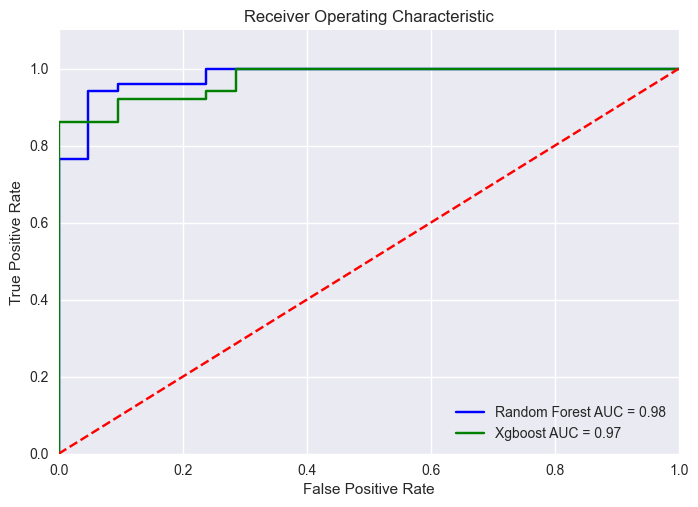

In [50]:
import matplotlib.pyplot as plt


# Create a list of model names and their corresponding colors for the plot
models_info = [
    ("Rf", "blue", "Random Forest"),
    ("Xgb", "green", "Xgboost")
]

plt.title('Receiver Operating Characteristic')

for model_name, color, label_text in models_info:
    fpr = models[model_name]["fpr"]
    tpr = models[model_name]["tpr"]
    auc_score = models[model_name]["auc_score"]
    plt.plot(fpr, tpr, color=color, label=f'{label_text} AUC = {auc_score:.2f}')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [40]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity", "auc_score"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        results['Rf'][metric]*100, results['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 
Random Forrest=94.44%, XGBoost=88.89% 

Sensitivity: 
Random Forrest=94.12%, XGBoost=92.16% 

Specificity: 
Random Forrest=95.24%, XGBoost=80.95% 

Auc_score: 
Random Forrest=98.04%, XGBoost=97.29% 



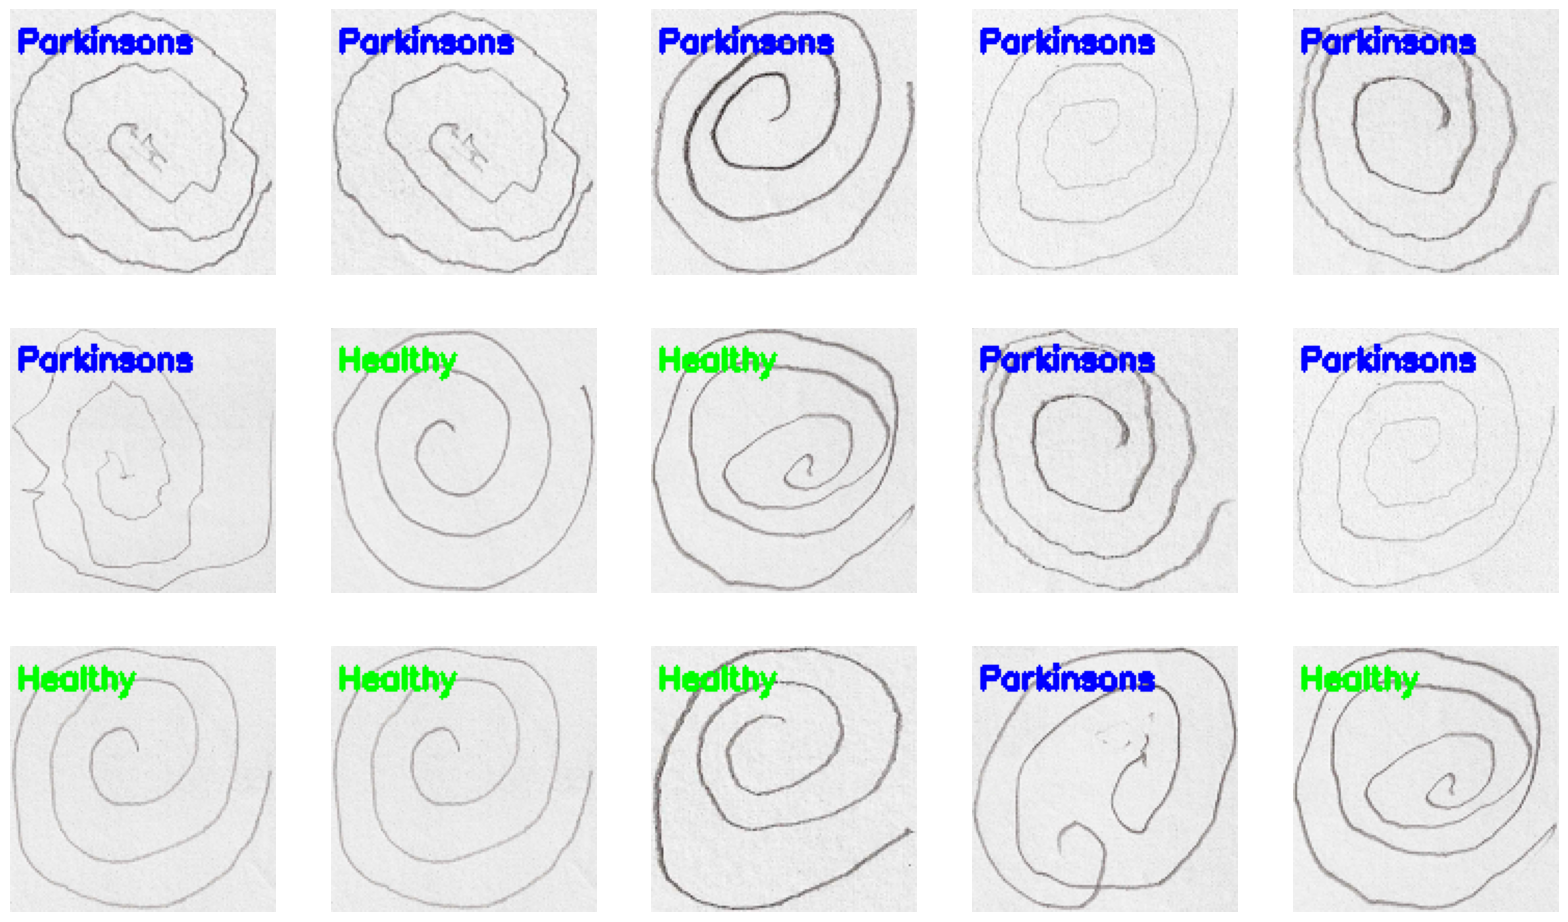

In [59]:
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import random

output_images = []
# pick 15 images at random
for _ in range(15):
    image_path = random.choice(y_list)
    image = cv2.imread(image_path)
    output = image.copy()
    output = cv2.resize(output, (128, 128))
    # pre-process the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # quantify the image and make predictions based on the extracted features
    features = feature.hog(image,
                           orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           transform_sqrt=transform_sqrt,
                           block_norm=block_norm)
    preds = results['Rf']['classifier'].predict([features])
    label = "Parkinsons" if preds[0] else "Healthy"

    # draw the colored class label on the output image and add it to
    # the set of output images
    color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
    cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    output_images.append(output)

# Display the images in a 5x5 grid
plt.figure(figsize=(20, 20))
for i, output_image in enumerate(output_images):
    plt.subplot(5, 5, i+1)
    plt.imshow(output_image)
    plt.axis("off")
plt.show()
